In [1]:
# ✅ دا لومړی چلوه
!pip install timm torchvision
!pip install sophia-opt seaborn tqdm


In [2]:
# دا باید د نورو imports سره وي
from sophia_opt import SophiaG
from tqdm import tqdm  # د progress bar لپاره


Mounted at /content/drive
Classes: ['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy'], Total Classes: 10


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/116M [00:00<?, ?B/s]

Epoch 1/10: 100%|██████████| 574/574 [53:17<00:00,  5.57s/it]


Epoch 1 | Loss: 0.4284 | Train Acc: 0.8596 | Val Acc: 0.9106


Epoch 2/10: 100%|██████████| 574/574 [06:43<00:00,  1.42it/s]


Epoch 2 | Loss: 0.2058 | Train Acc: 0.9315 | Val Acc: 0.9204


Epoch 3/10: 100%|██████████| 574/574 [06:44<00:00,  1.42it/s]


Epoch 3 | Loss: 0.1421 | Train Acc: 0.9534 | Val Acc: 0.9802


Epoch 4/10: 100%|██████████| 574/574 [06:43<00:00,  1.42it/s]


Epoch 4 | Loss: 0.0999 | Train Acc: 0.9689 | Val Acc: 0.9664


Epoch 5/10: 100%|██████████| 574/574 [06:45<00:00,  1.41it/s]


Epoch 5 | Loss: 0.0701 | Train Acc: 0.9767 | Val Acc: 0.9769


Epoch 6/10: 100%|██████████| 574/574 [06:44<00:00,  1.42it/s]


Epoch 6 | Loss: 0.0449 | Train Acc: 0.9858 | Val Acc: 0.9836


Epoch 7/10: 100%|██████████| 574/574 [06:44<00:00,  1.42it/s]


Epoch 7 | Loss: 0.0251 | Train Acc: 0.9913 | Val Acc: 0.9917


Epoch 8/10: 100%|██████████| 574/574 [06:44<00:00,  1.42it/s]


Epoch 8 | Loss: 0.0153 | Train Acc: 0.9950 | Val Acc: 0.9978


Epoch 9/10: 100%|██████████| 574/574 [06:45<00:00,  1.42it/s]


Epoch 9 | Loss: 0.0066 | Train Acc: 0.9979 | Val Acc: 0.9978


Epoch 10/10: 100%|██████████| 574/574 [06:44<00:00,  1.42it/s]


Epoch 10 | Loss: 0.0040 | Train Acc: 0.9986 | Val Acc: 0.9983

Classification Report:
                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot       1.00      1.00      1.00       425
                        Tomato___Early_blight       1.00      1.00      1.00       480
                         Tomato___Late_blight       1.00      1.00      1.00       463
                           Tomato___Leaf_Mold       1.00      1.00      1.00       470
                  Tomato___Septoria_leaf_spot       1.00      1.00      1.00       436
Tomato___Spider_mites Two-spotted_spider_mite       0.99      1.00      0.99       435
                         Tomato___Target_Spot       1.00      0.99      0.99       457
       Tomato___Tomato_Yellow_Leaf_Curl_Virus       1.00      1.00      1.00       490
                 Tomato___Tomato_mosaic_virus       1.00      1.00      1.00       448
                             Tomato___healt

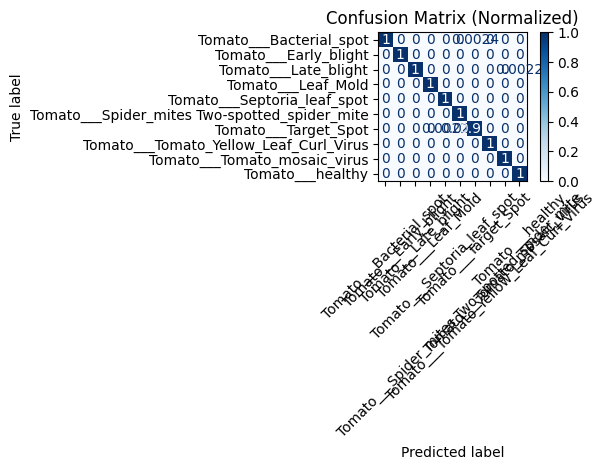

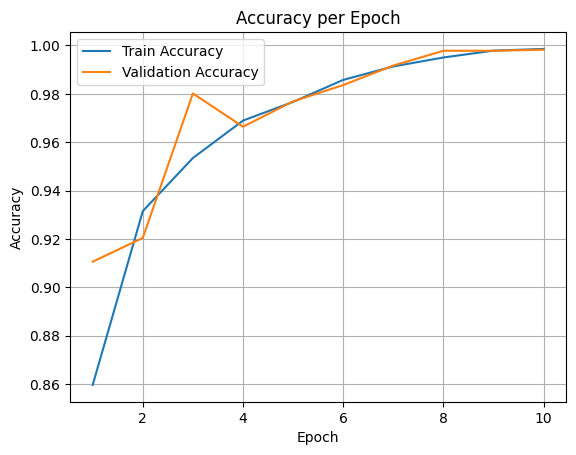

In [3]:
# ==================== IMPORTS ====================
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import timm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import (
    classification_report, confusion_matrix, f1_score, recall_score,
    precision_score, ConfusionMatrixDisplay
)
from sophia_opt import SophiaG
from torch.optim.lr_scheduler import CosineAnnealingLR
from google.colab import drive
from tqdm import tqdm

torch.backends.cudnn.benchmark = True  # ✅ For GPU speed optimization

# ==================== CONFIG ====================
drive.mount('/content/drive')
config = {
    'train_dir': '/content/drive/MyDrive/tomato/train',
    'val_dir': '/content/drive/MyDrive/tomato/valid',
    'image_size': 224,
    'batch_size': 32,
    'num_epochs': 10,
    'learning_rate': 1e-4,
    'weight_decay': 1e-5,
    'model_name': 'maxvit_tiny_rw_224',
    'save_path': '/content/best_maxvit_model.pth'
}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ==================== TRANSFORMS ====================
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(config['image_size'], scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
val_transforms = transforms.Compose([
    transforms.Resize((config['image_size'], config['image_size'])),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# ==================== DATASETS ====================
train_dataset = datasets.ImageFolder(root=config['train_dir'], transform=train_transforms)
val_dataset = datasets.ImageFolder(root=config['val_dir'], transform=val_transforms)
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=2)
num_classes = len(train_dataset.classes)
print(f"Classes: {train_dataset.classes}, Total Classes: {num_classes}")

# ==================== MODEL ====================
class CustomMaxViT(nn.Module):
    def __init__(self, base_model, num_classes):
        super().__init__()
        self.backbone = base_model
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Linear(base_model.num_features, num_classes)

    def forward(self, x):
        x = self.backbone.forward_features(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

base_model = timm.create_model(config['model_name'], pretrained=True, num_classes=0, global_pool='')
model = CustomMaxViT(base_model, num_classes).to(device)

# ==================== LOSS, OPTIMIZER, LR SCHEDULER ====================
criterion = nn.CrossEntropyLoss()
optimizer = SophiaG(model.parameters(),
                    lr=config['learning_rate'],
                    betas=(0.965, 0.99),
                    rho=0.01,
                    weight_decay=config['weight_decay'])
scheduler = CosineAnnealingLR(optimizer, T_max=config['num_epochs'])

# ==================== TRAINING LOOP ====================
best_accuracy = 0.0
train_accuracies, val_accuracies = [], []
k = 50
bs = config['batch_size']
iter_num = -1

for epoch in range(config['num_epochs']):
    model.train()
    running_loss = 0.0
    correct = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{config['num_epochs']}"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad(set_to_none=True)
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step(bs=bs)

        iter_num += 1
        if iter_num % k == k - 1:
            outputs = model(images)
            sampled = torch.distributions.Categorical(logits=outputs).sample()
            loss_samp = F.cross_entropy(outputs, sampled)
            loss_samp.backward()
            optimizer.update_hessian()

        running_loss += loss.item() * images.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()

    train_acc = correct / len(train_dataset)
    train_accuracies.append(train_acc)

    # Validation
    model.eval()
    val_correct = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_correct += (outputs.argmax(1) == labels).sum().item()

    val_acc = val_correct / len(val_dataset)
    val_accuracies.append(val_acc)
    scheduler.step()  # ⬅️ Step LR scheduler

    print(f"Epoch {epoch+1} | Loss: {running_loss/len(train_dataset):.4f} | "
          f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    if val_acc > best_accuracy:
        best_accuracy = val_acc
        torch.save(model.state_dict(), config['save_path'])

# ==================== EVALUATION ====================
model.load_state_dict(torch.load(config['save_path']))
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        preds = outputs.argmax(1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

# ==================== METRICS ====================
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=val_dataset.classes))
f1 = f1_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
precision = precision_score(all_labels, all_preds, average='macro')
print(f"F1 Score: {f1:.4f}, Recall: {recall:.4f}, Precision: {precision:.4f}")

# ==================== CONFUSION MATRIX ====================
cm = confusion_matrix(all_labels, all_preds, normalize='true')  # ✅ Normalized for percentage
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_dataset.classes)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Normalized)")
plt.grid(False)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ==================== ACCURACY CURVE ====================
plt.plot(range(1, config['num_epochs'] + 1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, config['num_epochs'] + 1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per Epoch")
plt.legend()
plt.grid(True)
plt.show()


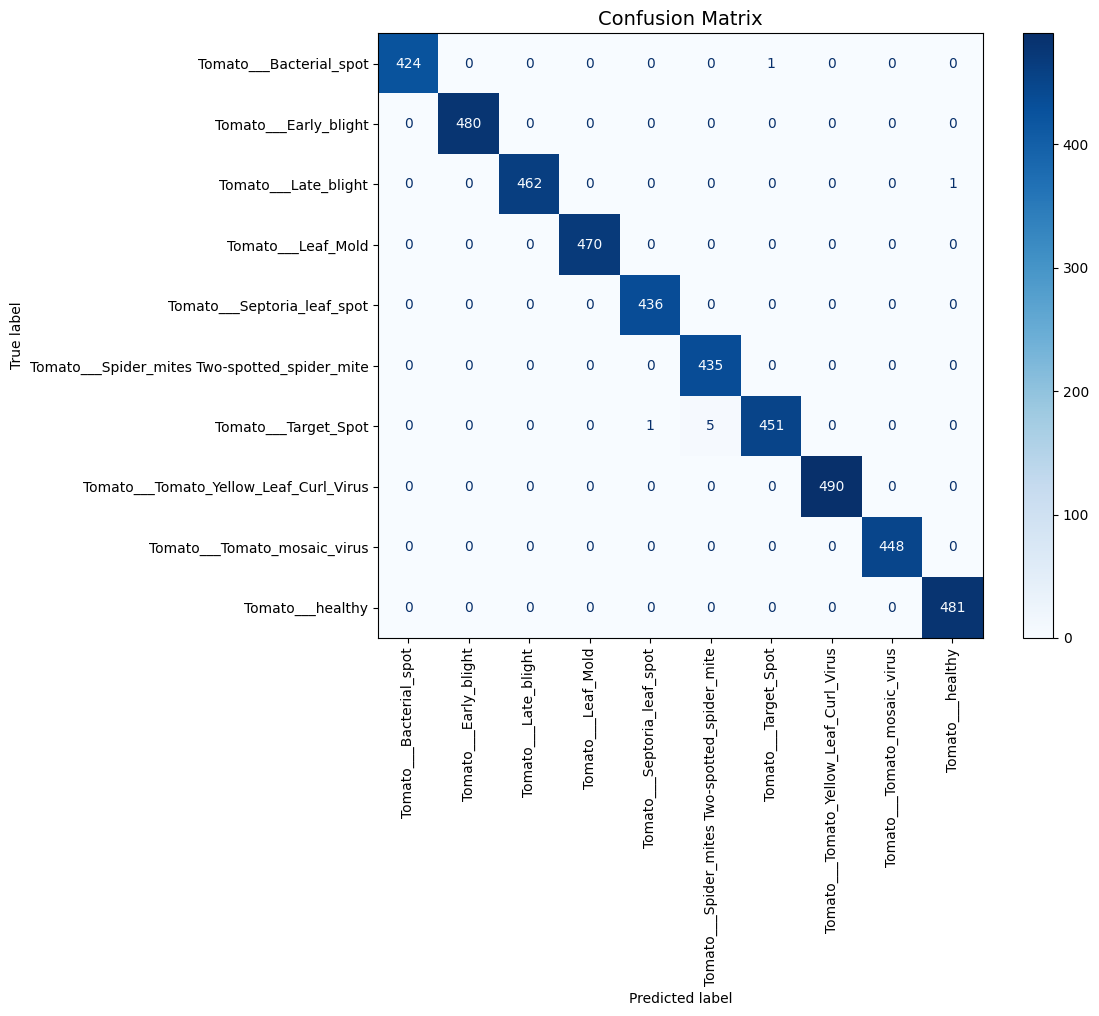

In [4]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)
class_names = val_dataset.classes

fig, ax = plt.subplots(figsize=(12, 10))  # پراخ figure
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, ax=ax)

# Rotate x-axis labels clearly
plt.xticks(rotation=90)

plt.title("Confusion Matrix", fontsize=14)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.grid(False)
plt.tight_layout()  # یا بدلول: plt.subplots(..., layout='constrained')
plt.show()
